In [1]:
#Download and import required libraries
!pip install ekphrasis
!pip install gensim
%matplotlib inline
!pip install tabulate
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import struct 

from gensim.models.word2vec import Word2Vec

from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

import io, re

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import nltk

import itertools

#Download required lists for preprocessing
nltk.download('stopwords')
nltk.download('wordnet')

#Set path of GloVe vectors
GLOVE_wiki50d_PATH = "glove.6B/glove.6B.50d.txt"
GLOVE_wiki200d_PATH = "glove.6B/glove.6B.200d.txt"

encoding="utf-8"

You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/PhilipADSo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/PhilipADSo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Download required GloVe vectors
# Can alreadt found in the glove.6B folder
#!pip install wget
#import zipfile
#import wget
# download GloVe word vector representations
#wget.download('http://nlp.stanford.edu/data/glove.6B.zip')
#zipped = zipfile.ZipFile('glove.6B.zip')
#zipped.extractall()

In [3]:
#Convert emotion labels
label2emotion = {0:"others", 1:"happy", 2: "sad", 3:"angry"}
emotion2label = {"others":0, "happy":1, "sad":2, "angry":3}

In [4]:
#Preprocess data
#script used from original code used in https://competitions.codalab.org/competitions/19790#learn_the_details-data-set-format
def preprocessData(dataFilePath, mode):
    """Load data from a file, process and return indices, conversations and labels in separate lists
    Input:
        dataFilePath : Path to train/test file to be processed
        mode : "train" mode returns labels. "test" mode doesn't return labels.
    Output:
        indices : Unique conversation ID list
        conversations : List of 3 turn conversations, processed and each turn separated by the <eos> tag
        labels : [Only available in "train" mode] List of labels
    """
    indices = []
    conversations = []
    labels = []
    with io.open(dataFilePath, encoding="utf8") as finput:
        finput.readline()
        for line in finput:
            # Convert multiple instances of . ? ! , to single instance
            # okay...sure -> okay . sure
            # okay???sure -> okay ? sure
            # Add whitespace around such punctuation
            # okay!sure -> okay ! sure
            repeatedChars = ['.', '?', '!', ',']
            for c in repeatedChars:
                lineSplit = line.split(c)
                while True:
                    try:
                        lineSplit.remove('')
                    except:
                        break
                cSpace = ' ' + c + ' '    
                line = cSpace.join(lineSplit)
            
            line = line.strip().split('\t')
            if mode == "train":
                # Train data contains id, 3 turns and label
                label = emotion2label[line[4]]
                labels.append(label)
            
            conv = ' <eos> '.join(line[1:4])
            
            # Remove any duplicate spaces
            duplicateSpacePattern = re.compile(r'\ +')
            conv = re.sub(duplicateSpacePattern, ' ', conv)
            
            indices.append(int(line[0]))
            conversations.append(conv.lower())
    
    if mode == "train":
        return indices, conversations, labels
    else:
        return indices, conversations

In [5]:
#Import data
trainIndices, trainTexts, labels = preprocessData("train.txt", mode="train")
testIndices, testTexts, testLabels = preprocessData("test.txt", mode="train")
devIndices, devTexts, devLabels = preprocessData("test.txt", mode="train")

#Combining dev and test set to be re-split in training
trainTexts += testTexts + devTexts
labels+= testLabels + devLabels

trainDF = pd.DataFrame({'convtrain': trainTexts,'labels': labels})

In [ ]:
#Stemming, lemmatisation and removing stopwords
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


In [15]:
#Ekphrasis pre-processing and apply other preprocessing
#https://github.com/cbaziotis/ekphrasis
all_words = []  
sentences = []
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

  
for index, row in trainDF.iterrows():
    tokenized = text_processor.pre_process_doc(row['convtrain'])
    preprocessed = lemmatize_verbs(stem_words(remove_stopwords(tokenized)))
    all_words.append(preprocessed)
    sentences.append(preprocessed)
    trainDF.set_value(index,'convtrain',preprocessed)

all_words = list(itertools.chain(*all_words))

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:40: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [16]:
# Confirm size of dataset
print('Trainset-sample size: {} '.\
      format(trainDF.shape[0]))

Trainset-sample size: 97208 


In [17]:
#Print data stats
def column_value_counts(df, target_column, new_column):
    '''
    Get value counts of each categorical variable. Store this data in 
    a dataframe. Also add a column with relative percentage of each 
    categorical variable.
    
    :param df: A Pandas dataframe
    :param target_column: Name of the column in the original dataframe (string)
    :param new_column: Name of the new column where the frequency counts are stored 
    :type df: pandas.core.frame.DataFrame
    :type target_column: str
    :type new_column: str
    :return: A Pandas dataframe containing the frequency counts
    :rtype: pandas.core.frame.DataFrame
    '''
    df_value_counts = df[target_column].value_counts()
    df = pd.DataFrame(df_value_counts)
    df.columns = [new_column]
    df[new_column+'_%'] = 100*df[new_column] / df[new_column].sum()
    return df

# Get frequency distribution of labels in each set
df_train = column_value_counts(trainDF, 'labels', 'Train')
# df_test = column_value_counts(testDF, 'labels', 'Test')

label_count = pd.concat([df_train], axis=1) # Merge dataframes by index
label_count = label_count.fillna(0) # Replace Nan with 0 (zero)
label_count = label_count.round(2) # Rounding decimals to two digits after .
label_count['Labelsn'] = ['Others','Angry','Sad','Happy']
print(label_count.sort_values(by=['Train'], ascending=False))

   Train  Train_% Labelsn
3  24302     25.0  Others
2  24302     25.0   Angry
1  24302     25.0     Sad
0  24302     25.0   Happy


In [19]:
# Reads the download GloVe files line by line and
# selects vectors that only correspond to the dataset
# If statement reduces the req amount of RAM

glove_small = {}
with open(GLOVE_wiki50d_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

            
glove_big = {}
with open(GLOVE_wiki200d_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

In [20]:
# Saves new vectors to file
filename1 = 'glove_small'
outfile1 = open(filename1,'wb')
pickle.dump(glove_small,outfile1)
outfile1.close()

filename2 = 'glove_big'
outfile2 = open(filename2,'wb')
pickle.dump(glove_big,outfile2)
outfile2.close()

In [21]:
# Loads vecrtors from file
glove_small = pickle.load( open( "glove_small", "rb" ) )
glove_big = pickle.load( open( "glove_big", "rb" ) )

In [22]:
# Vectoriser classes
# Word count vectoriser
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

    
# TD-IDF vectoriser
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [23]:
svc = Pipeline([("count_vectorizer", CountVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear", class_weight="balanced"))])
svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("linear svc", SVC(kernel="linear", class_weight="balanced"))])

In [24]:
# need
glove_small_svm = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("linear svc", SVC(kernel="linear", class_weight="balanced"))])
glove_small_tfidf_svm = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("linear svc", SVC(kernel="linear", class_weight="balanced"))])

glove_big_svm = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("linear svc", SVC(kernel="linear", class_weight="balanced"))])
glove_big_tfidf_svm = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("linear svc", SVC(kernel="linear", class_weight="balanced"))])


In [25]:
# need
all_models = [

    ("svc", svc),
    ("svc_tfidf", svc_tfidf),
    ("glove_small_svm" , glove_small_svm),
    ("glove_small_tfidf_svm", glove_small_tfidf_svm),
    ("glove_big_svm", glove_big_svm),
    ("glove_big_tfidf_svm", glove_big_tfidf_svm),

]


In [22]:
# need

unsorted_scores = [(name, cross_val_score(model, trainDF['convtrain'], trainDF['labels'], cv=5).mean()) for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])

print (tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-package

/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-package

model                        score
-------------------------  -------
log_reg                     0.6152
log_reg_tfidf               0.6087
glove_small_tfidf_log_reg   0.5427
glove_big_tfidf_log_reg     0.5426
glove_small_log_reg         0.5423
glove_big_log_reg           0.5423
svc                         0.5143
svc_tfidf                   0.4810
glove_small_tfidf_svm       0.3660
glove_big_tfidf_svm         0.3660
glove_small_svm             0.3631
glove_big_svm               0.3631


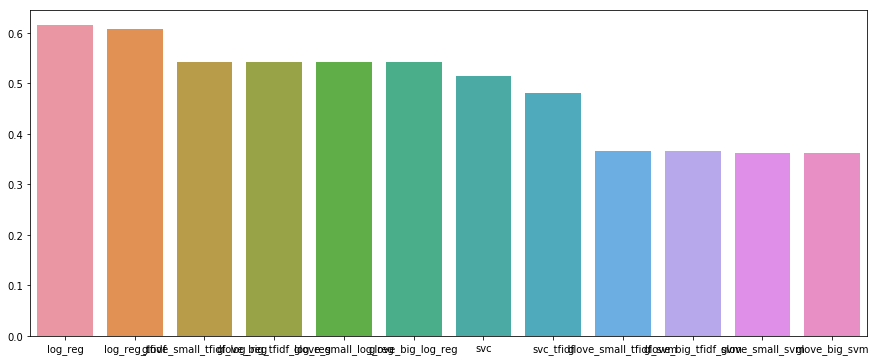

In [23]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores])

In [27]:
#Returns evaluation metrics
def benchmark(model, data, labels, n):
    '''
    Ten-fold cross-validation with stratified sampling.
    '''
    test_size = 1 - (n / float(trainDF.shape[0]))
    accuracyscores = []
    precisionscores = []
    recallscores = []
    f1scores = []
    f1scoremicro = []
    f1scoremacro = []

    confusionscores = []
    sss = StratifiedShuffleSplit()
    for train_index, test_index in sss.split(data, labels):
        x_train, x_test = data[train_index], data[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
          
        accuracyscores.append(accuracy_score(y_test, y_pred))
        precisionscores.append(precision_score(y_test, y_pred, average=None))
        recallscores.append(recall_score(y_test, y_pred, average=None))
        f1scores.append(f1_score(y_test, y_pred, average=None))
        f1scoremicro.append(f1_score(y_test, y_pred, average="micro"))
        f1scoremicro.append(f1_score(y_test, y_pred, average="macro"))

        confusionscores.append(confusion_matrix(y_test, y_pred))
 
    return [np.mean(accuracyscores, axis=0),np.mean(precisionscores, axis=0),np.mean(recallscores, axis=0),np.mean(f1scores, axis=0),np.mean(confusionscores, axis=0),np.mean(f1scoremicro, axis=0),np.mean(f1scoremacro, axis=0)]

In [ ]:
# Fits the model with different training sizes
train_sizes = [5, 8, 10, 13, 15, 18, 20, 30, 60, 230, 400, 600]
table = []
for name, model in all_models:
    for n in train_sizes:
        modelResults = benchmark(model, trainDF['convtrain'],trainDF['labels'], n)
  
        PreOthers, PreAngry, PreSad, PreHappy = modelResults[1]
        RecOthers, RecAngry, RecSad, RecHappy = modelResults[2]
        F1Others, F1Angry, F1Sad, F1Happy = modelResults[3]

        table.append({'Model': name, 
                      'Accuracy': modelResults[0], 
                      'PreOthers': PreOthers,
                      'PreAngry': PreAngry,
                      'PreSad': PreSad,
                      'PreHappy': PreHappy,
                      'RecOthers': RecOthers,
                      'RecAngry': RecAngry,
                      'RecSad': RecSad,
                      'RecHappy': RecHappy,
                      'F1Others': F1Others,
                      'F1Angry': F1Angry,
                      'F1Sad': F1Sad,
                      'F1Happy': F1Happy,
                      'F1micro' : modelResults[5],
                      'F1macro': modelResults[6],
                      'Confusion': modelResults[4],
                      'train_size': n})
        
df = pd.DataFrame(table)

/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/PhilipADSo/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
# required to label each plot
metric2labeler = {'Accuracy': "Accuracy",'PreOthers': "Others class: Precision",'PreAngry': "Angry class: Precision",'PreSad': "Sad class: Precision",'PreHappy': "Happy class: Precision",
                'RecOthers':"Others class: Recall",'RecAngry':"Angry class: Recall",'RecSad':"Sad class: Recall",'RecHappy':"Happy class: Recall",
                'F1Others':"Others class: F1",'F1Angry':'Angry class: F1Angry','F1Sad':"Sad class: F1",'F1Happy':"Happy class: F1",'F1micro':"F1 Micro",'F1macro':"F1 Macro"}

In [ ]:
# Plots how each metric changes with the size
metricList = ['Accuracy','PreOthers','PreAngry','PreSad','PreHappy','RecOthers','RecAngry','RecSad','RecHappy','F1Others','F1Angry','F1Sad','F1Happy']

for metricC in metricList:
    plt.figure(figsize=(15, 6))
    fig = sns.pointplot(x='train_size', y=metricC, hue='Model', 
                        data=df[df.Model.map(lambda x: x in ["svc","svc_tfidf","glove_small_svm","glove_small_tfidf_svm","glove_small_log_reg","glove_small_tfidf_log_reg","glove_big_log_reg","glove_big_tfidf_log_reg","glove_big_svm","glove_big_tfidf_svm"])])
    sns.set_context("paper", font_scale=1.5)
    fig.set(ylabel=metricC)
    fig.set(xlabel="labeled training examples")
    fig.set(title='{} against training size'.\
      format(metric2labeler[metricC]))
    

In [ ]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):

    # Only use the labels that appear in the data
    classes = ['Others','Angry','Sad','Happy']
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [ ]:
# Plotting specific metrics
for index, row in df.iterrows():
        print( row['Model'],row['train_size'], row['Accuracy'])

In [ ]:
# Plots the confusion matrix for each class and metric
plt.figure(figsize=(15, 6))
metricList = ['PreOthers','PreAngry','PreSad','PreHappy','RecOthers','RecAngry','RecSad','RecHappy','F1Others','F1Angry','F1Sad','F1Happy']

for metricC in metricList:
    for index, row in df.iterrows():
        np.set_printoptions(precision=2)
        print( row['Model'],row['train_size'])
        # Plot non-normalized confusion matrix
        # plot_confusion_matrix(row['Confusion'], classes=['Others','Angry','Sad','Happy'],
        #                  title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        plot_confusion_matrix(row['Confusion'], classes=['Others','Angry','Sad','Happy'], normalize=True,
                          title='Normalized confusion matrix')

        plt.show()

In [51]:
# Saves result
filename1 = 'Results'
outfile1 = open(filename1,'wb')
pickle.dump(df,outfile1)
outfile1.close()
